In [1]:
# Imports
# General
import sys
sys.path.append('../')
import json

# drawing
import  matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import confusion_matrix

# statistics
import numpy as np
import pandas as pd

# from watermark_eval.functions import evaluate_text_quality_ppl
import math
import os
import copy

import glob
import re
from multiprocessing import Pool

# NLP
import nltk
from nltk.translate.bleu_score import SmoothingFunction

# from rouge import Rouge
# from sacrebleu import sentence_bleu
from rouge_score import rouge_scorer
import evaluate

/home/malghanim/anaconda3/envs/watermarking/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_parameters_vocab_based(filename):
    # add that a string "para_trans" or nothing is allowed
    pattern = re.compile(
        r'_(?P<task>c4|lfqa)_examples=\d+_src=(?P<src>Arabic|English|Chinese|Indonesian)_(?P<model>jais|sail|r7b)_tgt=(?P<tgt>Arabic|English|Chinese|Indonesian)_(?P<method>kgw|unigram)_delta=(?P<delta>[0-9.]+)_gamma=(?P<gamma>[0-9.]+)',
        re.IGNORECASE
    )
    match = pattern.search(filename)
    return match.group('task'), match.group('src'), match.group('model'), match.group('tgt'), match.group('method'), float(match.group('delta')), float(match.group('gamma'))

def extract_parameters_semantic_based(filename):
    # add that a string "para_trans" or nothing is allowed
    pattern = re.compile(
        r'_(?P<task>c4|lfqa)_examples=\d+_src=(?P<src>Arabic|English|Chinese|Indonesian)_(?P<model>jais|sail|r7b)_tgt=(?P<tgt>Arabic|English|Chinese|Indonesian)_(?P<method>xsir)_delta=(?P<delta>[0-9.]+)',
        re.IGNORECASE
    )
    match = pattern.search(filename)
    return match.group('task'), match.group('src'), match.group('model'), match.group('tgt'), match.group('method'), float(match.group('delta'))

def extract_parameters_sampling_based(filename):
    pattern = re.compile(
        r'_(?P<task>c4|lfqa)_examples=\d+_src=(?P<src>Arabic|English|Chinese|Indonesian)_(?P<model>jais|sail|r7b)_tgt=(?P<tgt>Arabic|English|Chinese|Indonesian)_(?P<method>exp)',
        re.IGNORECASE
    )
    match = pattern.search(filename)
    return match.group('task'), match.group('src'), match.group('model'), match.group('tgt'), match.group('method')
lang_dict_acronym = {"Arabic": "ar", "English": "en", "Chinese": "zh", "Indonesian": "id"}

In [3]:
# Find all jsonl files in the specified directory
languages = ['English', 'Arabic', 'Chinese', 'Indonesian']

experiment = 'attack'
all_methods = ['KGW', 'Unigram', 'XSIR', 'EXP']
file_dict = {}

for language in languages:
    file_dict[language] = {}
    for method in all_methods:
        file_path = f'../outputs/{experiment}/{method}/{language}/*.json'
        files = glob.glob(file_path)
        file_dict[language][method] = files


# Initialize an empty list to store the data
all_data = []


# Read each file and append its content to the list
for language in file_dict:
  for method in file_dict[language]:
    for file in file_dict[language][method]:
      with open(file, 'r') as f:
        data = json.load(f)
        if method == 'XSIR':
          task, src, model, tgt, _, delta = extract_parameters_semantic_based(file)
          if task == 'lfqa' or model == 'r7b':
            continue
          if delta == 2.0:
            all_data.append({'task': task, 'src_lang': src, 'model': model,'tgt_lang': tgt, 'method': method, 'delta': delta, 'data': data})
        elif method == 'EXP':
          task, src, model, tgt, _ = extract_parameters_sampling_based(file)
          if task == 'lfqa' or model == 'r7b':
            continue
          all_data.append({'task': task, 'src_lang': src, 'model': model, 'tgt_lang': tgt, 'method': method, 'data': data})
        else:
          task, src, model, tgt, _, delta, gamma = extract_parameters_vocab_based(file)
          if task == 'lfqa' or model == 'r7b':
            continue
          if gamma == 0.5 and delta == 2.0:
          # print(f"src: {src}, tgt: {tgt}, pipeline: {pipeline}, delta: {delta}, gamma: {gamma}")
            all_data.append({'task': task, 'src_lang': src, 'model': model, 'tgt_lang': tgt, 'method': method, 'delta': delta, 'gamma': gamma, 'data': data})


In [4]:
print(len(all_data))

36


In [5]:
# Print keys and values of all_data
print("All Data:")
for item in all_data:
    print({key: (value if key != 'data' else "data") for key, value in item.items()})
    print("\n")

All Data:
{'task': 'c4', 'src_lang': 'English', 'model': 'sail', 'tgt_lang': 'Chinese', 'method': 'KGW', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'sail', 'tgt_lang': 'Indonesian', 'method': 'KGW', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'jais', 'tgt_lang': 'Arabic', 'method': 'KGW', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'sail', 'tgt_lang': 'Chinese', 'method': 'Unigram', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'jais', 'tgt_lang': 'Arabic', 'method': 'Unigram', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'sail', 'tgt_lang': 'Indonesian', 'method': 'Unigram', 'delta': 2.0, 'gamma': 0.5, 'data': 'data'}


{'task': 'c4', 'src_lang': 'English', 'model': 'jais', 'tgt_lang': 'Arabic', 'method': 'XSIR', 'delta': 2.0, 'data': 'data'}


{

In [6]:
delta = 2.0
gamma = 0.5

In [7]:
# initialize dictionaries for KGW data

attack_data_pipeline_1 = {
    'src_lang': ["English", "English", "English", "Arabic", "Chinese", "Indonesian"],
    'tgt_lang': ["Arabic", "Chinese", "Indonesian", "English", "English", "English"],
    'scores': [None] * 6,
    'examples': [None] * 6,
}
attack_data_pipeline_2 = {
    'src_lang': ["English", "English", "English", "Arabic", "Chinese", "Indonesian"],
    'tgt_lang': ["Arabic", "Chinese", "Indonesian", "English", "English", "English"],
    'scores': [None] * 6,
    'examples': [None] * 6,
}
attack_data_pipeline_3 = {
    'src_lang': ["English", "English", "English", "Arabic", "Chinese", "Indonesian"],
    'tgt_lang': ["Arabic", "Chinese", "Indonesian", "English", "English", "English"],
    'scores': [None] * 6,
    'examples': [None] * 6,
}
# create pandas dataframes for each dict
attack_data_pipeline_1_df = pd.DataFrame(attack_data_pipeline_1)
attack_data_pipeline_2_df = pd.DataFrame(attack_data_pipeline_2)
attack_data_pipeline_3_df = pd.DataFrame(attack_data_pipeline_3)

# create a dictionary to store the dataframes
df_dict = {
    'KGW': {
        'translation': attack_data_pipeline_1_df,
        'translation->paraphrase': attack_data_pipeline_2_df,
        'paraphrase->translation': attack_data_pipeline_3_df
    },
    'Unigram': {
        'translation': copy.deepcopy(attack_data_pipeline_1_df),
        'translation->paraphrase': copy.deepcopy(attack_data_pipeline_2_df),
        'paraphrase->translation': copy.deepcopy(attack_data_pipeline_3_df)
    },
    'XSIR': {
        'translation': copy.deepcopy(attack_data_pipeline_1_df),
        'translation->paraphrase': copy.deepcopy(attack_data_pipeline_2_df),
        'paraphrase->translation': copy.deepcopy(attack_data_pipeline_3_df)
    },
    'EXP': {
        'translation': copy.deepcopy(attack_data_pipeline_1_df),
        'translation->paraphrase': copy.deepcopy(attack_data_pipeline_2_df),
        'paraphrase->translation': copy.deepcopy(attack_data_pipeline_3_df)
    }
}

In [8]:
df_dict['KGW'], df_dict['Unigram']

({'translation':      src_lang    tgt_lang scores examples
  0     English      Arabic   None     None
  1     English     Chinese   None     None
  2     English  Indonesian   None     None
  3      Arabic     English   None     None
  4     Chinese     English   None     None
  5  Indonesian     English   None     None,
  'translation->paraphrase':      src_lang    tgt_lang scores examples
  0     English      Arabic   None     None
  1     English     Chinese   None     None
  2     English  Indonesian   None     None
  3      Arabic     English   None     None
  4     Chinese     English   None     None
  5  Indonesian     English   None     None,
  'paraphrase->translation':      src_lang    tgt_lang scores examples
  0     English      Arabic   None     None
  1     English     Chinese   None     None
  2     English  Indonesian   None     None
  3      Arabic     English   None     None
  4     Chinese     English   None     None
  5  Indonesian     English   None     None},
 {'

In [9]:
attack_pipeline = ['translation', 'translation->paraphrase', 'paraphrase->translation']
z_scores = []
trans_attack_z_scores = []
trans_para_attack_z_scores = []
para_trans_attack_z_scores = []
trans_attack_examples = []
trans_para_attack_examples = []
para_trans_attack_examples = []


for data in all_data:
    z_scores_col_name = 'z_scores'
    src_language = data['src_lang']
    tgt_language = data['tgt_lang']
    model = data['model']
    method = data['method']
    if method == 'EXP':
        z_scores_col_name = 'pvals'
    inner_data = data['data'][:100] # only available en-ar, zh-en, id-en, ar-en for kgw adn unigram (8 files)
    try:
        for idx, elements in enumerate(inner_data):
            unwm_z_scores, unwm_trans_scores, wm_z_scores = elements[z_scores_col_name][1], elements['unwm_translated_score'], elements[z_scores_col_name][2]
            
            # if idx == 0:
            #     print(elements['z_scores'])
            trans_attack_z_scores.append([unwm_trans_scores, unwm_z_scores, wm_z_scores, elements['attacked_score1']]) # translation scores before and after
            if method == "XSIR" and (src_language == 'English' and tgt_language == 'Chinese'):
                unwm_trans_para_scores = elements['unwm_translated_paraphrased_score']
                trans_para_attack_z_scores.append([unwm_trans_para_scores, unwm_z_scores, wm_z_scores, elements['attacked_score2']]) # translation->paraphrase scores
            else:
                trans_para_attack_z_scores.append([unwm_trans_scores, unwm_z_scores, wm_z_scores, elements['attacked_score2']]) # translation->paraphrase scores
            trans_attack_examples.append([elements['original_wm1'], elements['attacked_wm1']])
            trans_para_attack_examples.append([elements['original_wm2'], elements['attacked_wm2']])

            # if src_language == 'English':
            para_trans_attack_z_scores.append([unwm_z_scores, wm_z_scores, elements['attacked_score3']]) # paraphrase->translation scores
            para_trans_attack_examples.append([elements['original_wm3'], elements['attacked_wm3']])
        # df = None
        # if src_language == 'English':
        df = df_dict[method]['paraphrase->translation']
        index = df[(df['src_lang'] == src_language) & (df['tgt_lang'] == tgt_language)].index[0]
        df.at[index, 'scores'] = para_trans_attack_z_scores
        df.at[index, 'examples'] = para_trans_attack_examples
            
        df = df_dict[method]['translation']
        index = df[(df['src_lang'] == src_language) & (df['tgt_lang'] == tgt_language)].index[0]
        df.at[index, 'scores'] = trans_attack_z_scores
        df.at[index, 'examples'] = trans_attack_examples

        df = df_dict[method]['translation->paraphrase']
        index = df[(df['src_lang'] == src_language) & (df['tgt_lang'] == tgt_language)].index[0]
        df.at[index, 'scores'] = trans_para_attack_z_scores
        df.at[index, 'examples'] = trans_para_attack_examples

    except Exception as e:
        print(e)
        print(method)
        print(src_language, tgt_language)
        print(elements['index'])
        if method in ['KGW', 'Unigram']:
            print(f"model {model}, delta {data['delta']} gamma {data['gamma']}")
        elif method == 'XSIR':
            print(f"model {model}, delta {data['delta']}")
        else:
            print(f"model {model}")
    
    # reinitialize the lists
    trans_attack_z_scores = []
    trans_para_attack_z_scores = []
    para_trans_attack_z_scores = []
    trans_attack_examples = []
    trans_para_attack_examples = []
    para_trans_attack_examples = []

In [10]:
from IPython.display import display

# pretty pring the dataframe
display(df_dict['KGW'])
display(df_dict['Unigram'])
display(df_dict['XSIR'])
display(df_dict['EXP'])


{'translation':      src_lang    tgt_lang                                             scores  \
 0     English      Arabic  [[0.07312724241271307, -2.1975317355258412, 9....   
 1     English     Chinese  [[0.9258200997725514, -0.6512171447631795, 5.9...   
 2     English  Indonesian  [[1.4142135623730951, -0.6512171447631795, 5.9...   
 3      Arabic     English  [[-1.6644794391276478, -0.21266436150250076, 1...   
 4     Chinese     English  [[2.013666387631056, 1.2344267996967353, 8.993...   
 5  Indonesian     English  [[0.3375263702778072, 0.2886751345948129, 4.22...   
 
                                             examples  
 0  [[ Dorial Green-Beckham, whose last two season...  
 1  [[ is here only now.\n“The next 10 days I’ll b...  
 2  [[ is here only now.\n“The next 10 days I’ll b...  
 3  [[ تتمكن من الحصول عليها إلا بشق الأنفاس وبسعر...  
 4  [[�平\n��囗�桓�Ｊ��暋�Ｖ��濁��锛�鏅��鑾��鎻�鏅�鐗�鏅�忂�闁�锛...  
 5  [[ supaya cepat tinggi dalam tempo singkat seh...  ,
 'translation->paraphra

{'translation':      src_lang    tgt_lang                                             scores  \
 0     English      Arabic  [[1.021054940485262, 1.979898987322333, 9.3338...   
 1     English     Chinese  [[-0.5384615384615384, -0.07198157507486945, 8...   
 2     English  Indonesian  [[1.6448469449747105, -0.07198157507486945, 8....   
 3      Arabic     English  [[2.1082926644998015, 1.979898987322333, 10.32...   
 4     Chinese     English  [[-2.074251915366926, 3.597752107180135, 10.44...   
 5  Indonesian     English  [[-0.4472135954999579, 2.351152649601018, 7.85...   
 
                                             examples  
 0  [[ T.O. Hall, the projected opening-day starte...  
 1  [[ knows he can’t just be content with the sam...  
 2  [[ knows he can’t just be content with the sam...  
 3  [[ تجد من سبيل سوى الاستدانة... مع أنها بدأت ت...  
 4  [[��諏���嶻簉��唬��瀹�\n���𧽦�\n��鍛��𧽦�\n��隽��𫁑���鍛�...  
 5  [[ supaya cepat tinggi persisnya 3-7cm dalam w...  ,
 'translation->paraphra

{'translation':      src_lang    tgt_lang                                             scores  \
 0     English      Arabic  [[-0.021040272972222124, -0.07206062816671635,...   
 1     English     Chinese  [[0.13932287789670364, -0.05010502776792629, 0...   
 2     English  Indonesian  [[-0.13012288372014083, -0.05010502776792629, ...   
 3      Arabic     English  [[-0.3156417785489813, 0.16002203096194487, 0....   
 4     Chinese     English  [[0.19079880112851108, -0.0489829370842105, 0....   
 5  Indonesian     English  [[0.243589129618236, -0.05837946899442209, 0.5...   
 
                                             examples  
 0  [[ Robert Woods, of Thrift Shops of Baton Rogu...  
 1  [[ won’t be rushing to college. He has done so...  
 2  [[ won’t be rushing to college. He has done so...  
 3  [[ تستطيع التدفئة إلا في بعض المنازل.... إن وج...  
 4  [[支、非法买卖飞机飞机后，马超群是嫌疑人，没有疑点，公安机关立即将公诉机关起诉马超群的相关...  
 5  [[ agar cepat tinggi serta untuk menjaga stami...  ,
 'translation->paraphra

{'translation':      src_lang    tgt_lang                                             scores  \
 0     English      Arabic  [[0.4066494634338248, 0.9914615085682797, 1.15...   
 1     English     Chinese  [[0.5585832702304575, 0.724838780654203, 2.621...   
 2     English  Indonesian  [[0.9948026112806122, 0.724838780654203, 2.621...   
 3      Arabic     English  [[0.7113691517494795, 0.30969269741066463, 1.0...   
 4     Chinese     English  [[0.9999999995651183, 0.1860723301028172, 8.76...   
 5  Indonesian     English  [[0.9318782475529429, 0.18202433045932834, 5.7...   
 
                                             examples  
 0  [[.\nNFL, it typically only starts when the te...  
 1  [[ like the other young NFL superstar players,...  
 2  [[ like the other young NFL superstar players,...  
 3  [[ تكون قادرة على الصمود أكثر من الشهر تقريبا ...  
 4  [[�峰�薅�humanitarian art _humanitarian patrioti...  
 5  [[ supaya cepat tinggi dalam waktu yang relati...  ,
 'translation->paraphra

In [48]:
def calculate_precision_rates(z_scores_list, threshold=4.0, method = 'KGW', scores_len=4):
    # Initialize counts
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    # Process each set of z-scores for gold, unwatermarked, and watermarked
    for z in z_scores_list:
        # print(z)
        if scores_len == 4:
            unwm, _, _, attacked_wm, = z
        else:
            unwm, _, attacked_wm = z

        if method == "KGW" or method == "Unigram":
            # Check conditions
            if unwm >= threshold:
                false_positive += 1
            else:
                true_negative += 1
            
            if attacked_wm < threshold:
                false_negative += 1
            else:
                true_positive += 1
        elif method == 'XSIR':
            # Check conditions
            if unwm >= threshold:
                false_positive += 1
            else:
                true_negative += 1

            if attacked_wm < threshold:
                false_negative += 1
            else:
                true_positive += 1

        else: # EXP
            # Check conditions
            if unwm <= threshold:
                false_positive += 1
            else:
                true_negative += 1

            if attacked_wm > threshold:
                false_negative += 1
            else:
                true_positive += 1

    # Calculate rates
    TPR = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    FPR = false_positive / (false_positive + true_negative) if (false_positive + true_negative) != 0 else 0
    FNR = false_negative / (false_negative + true_positive) if (false_negative + true_positive) != 0 else 0
    TNR = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    return TPR, TNR, FPR, FNR

In [ ]:
# Iterate over DataFrame and calculate error rates
for method in df_dict.keys():
    threshold = 4
    if method == "XSIR":
        threshold = 0.2
    elif method == "EXP":
        threshold = 0.0001
    for attack_type, df in df_dict[method].items():
        # calculate the precision rates for rows with z-scores not None
        scores_len = 4
        if attack_type == 'paraphrase->translation':
            scores_len = 3
        df[['TPR', 'TNR', 'FPR', 'FNR']] = df['scores'].apply(lambda z_scores_list: pd.Series(calculate_precision_rates(z_scores_list, threshold, method, scores_len)))

In [ ]:
# Display updated DataFrame
for method, dict_vals in df_dict.items():
    for attack_type, df in dict_vals.items():
        print(f'{method} {attack_type}:\n', df[['src_lang', 'tgt_lang', 'TPR', 'TNR', 'FPR', 'FNR']])


KGW translation:
      src_lang    tgt_lang   TPR   TNR   FPR   FNR
0     English      Arabic  0.00  1.00  0.00  1.00
1     English     Chinese  0.01  1.00  0.00  0.99
2     English  Indonesian  0.01  1.00  0.00  0.99
3      Arabic     English  0.05  0.99  0.01  0.95
4     Chinese     English  0.09  1.00  0.00  0.91
5  Indonesian     English  0.07  1.00  0.00  0.93
KGW translation->paraphrase:
      src_lang    tgt_lang   TPR   TNR   FPR   FNR
0     English      Arabic  0.00  1.00  0.00  1.00
1     English     Chinese  0.01  1.00  0.00  0.99
2     English  Indonesian  0.01  1.00  0.00  0.99
3      Arabic     English  0.01  0.99  0.01  0.99
4     Chinese     English  0.06  1.00  0.00  0.94
5  Indonesian     English  0.03  1.00  0.00  0.97
KGW paraphrase->translation:
      src_lang    tgt_lang   TPR   TNR   FPR   FNR
0     English      Arabic  0.10  1.00  0.00  0.90
1     English     Chinese  0.08  1.00  0.00  0.92
2     English  Indonesian  0.20  1.00  0.00  0.80
3      Arabic     Engl

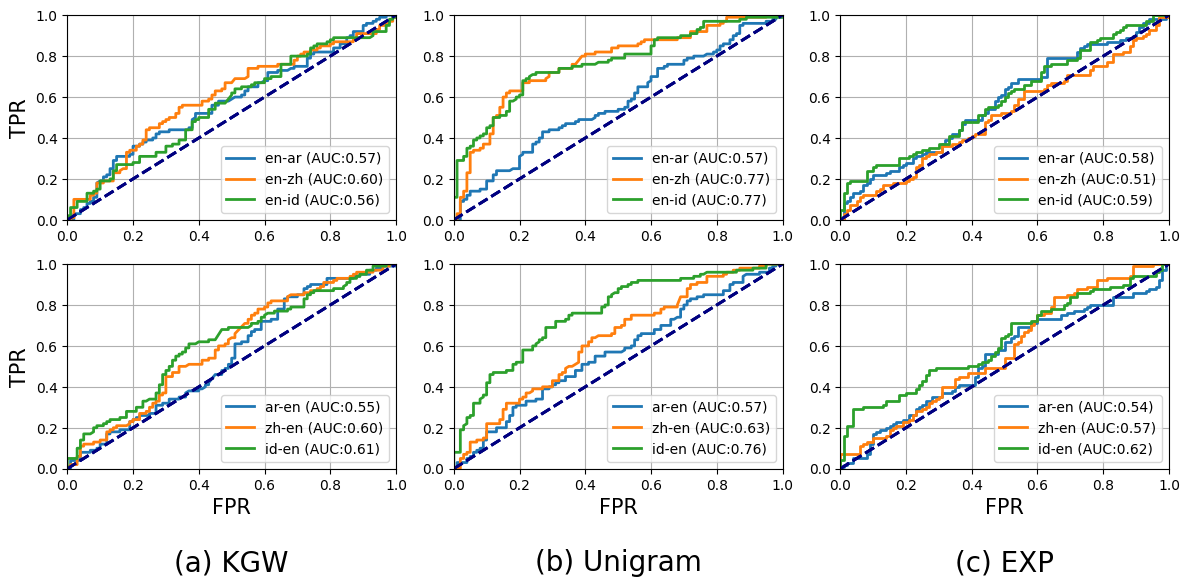

In [11]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves_selected_methods(fpr_range=(0.0, 1.0), delta=2.0, suffix="", attack_to_consider="translation"):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    low, high = fpr_range
    save_path = f'figures/roc_curves_selected_methods_{suffix}.pdf'
    methods_to_consider = ["KGW", "Unigram", "EXP"]
    source_languages = ["English"]
    target_languages = ["Arabic", "Chinese", "Indonesian"]
    
    for method_index, method in enumerate(methods_to_consider):
        attack_dataframes = df_dict[method]
        for attack_index, (attack_type, df) in enumerate(attack_dataframes.items()):
            if attack_type != attack_to_consider:
                continue
            for row in df.itertuples():
                if row.src_lang in source_languages and row.tgt_lang in target_languages:
                    ax = axes[0, method_index]
                elif row.src_lang in target_languages and row.tgt_lang in source_languages:
                    ax = axes[1, method_index]
                else:
                    continue
                try:
                    scores = np.array(row.scores)
                    true_scores = scores[:, 0]
                    predicted_scores = scores[:, 2]
                    if attack_type != "paraphrase->translation":
                        true_scores = scores[:, 0]
                        predicted_scores = scores[:, 3]
                    y_true = np.concatenate((np.zeros(100), np.ones(100)))
                    y_scores = np.hstack([true_scores, predicted_scores])
                    if method == 'EXP':
                        y_scores = -y_scores
                    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                    roc_auc = auc(fpr, tpr)
                    label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]} (AUC:{roc_auc:.2f})"
                    ax.plot(fpr, tpr, lw=2, label=label)
                except ValueError as e:
                    print(f"Error: {e}")
                    print(f"For {row.src_lang}->{row.tgt_lang} {attack_type}")
                    # print(f"y_scores {y_scores}")
                    # print(f"fpr {fpr} \n tpr {tpr}")
                    # replace the nan values with 0 in the y_scores
                    scores = np.nan_to_num(row.scores)
                    true_scores = scores[:, 0]
                    predicted_scores = scores[:, 2]
                    if attack_type != "paraphrase->translation":
                        true_scores = scores[:, 0]
                        predicted_scores = scores[:, 3]
                    y_scores = np.hstack([true_scores, predicted_scores])
                    if method == 'EXP':
                        y_scores = -y_scores
                    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                    roc_auc = auc(fpr, tpr)
                    label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]} (AUC:{roc_auc:.2f})"
                    ax.plot(fpr, tpr, lw=2, label=label)

                ax.tick_params(axis='both', which='major', labelsize=10)
                ax.plot([0, high], [0, high], color='navy', lw=2, linestyle='--')
                ax.set_xlim([low, high])  # Set x-axis limits to zoom in
                ax.set_ylim([low, high])  # Adjust y-axis to focus on higher TPR values
                ax.get_xaxis().get_major_formatter().set_scientific(True)
                # if method_index >= 3:
                axes[1, method_index].set_xlabel('FPR', fontsize=15)
                # if attack_index == 0:
                axes[0, 0].set_ylabel('TPR', fontsize=15)
                axes[1, 0].set_ylabel('TPR', fontsize=15)
                ax.legend(loc="lower right", fontsize=10)
                ax.grid(True)
    # Add letters under each column
    letters = ['(a) KGW', '(b) Unigram', '(c) EXP']
    
    for i, ax in enumerate(axes[1]):
        ax.text(0.5, -0.5, letters[i], transform=ax.transAxes, ha='center', fontsize=20)#, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

# Plot ROC curves for selected methods
attack_needed = "translation->paraphrase"
plot_roc_curves_selected_methods(fpr_range=(0.0, 1.0), suffix=f"kgw_unigram_exp_{attack_needed}_with_numbering", attack_to_consider=attack_needed)


Error: Input contains NaN.
For English->Indonesian translation
Error: Input contains NaN.
For Arabic->English translation
Error: Input contains NaN.
For English->Indonesian translation->paraphrase
Error: Input contains NaN.
For Chinese->English translation->paraphrase
Error: Input contains NaN.
For English->Indonesian paraphrase->translation
Error: Input contains NaN.
For Chinese->English paraphrase->translation


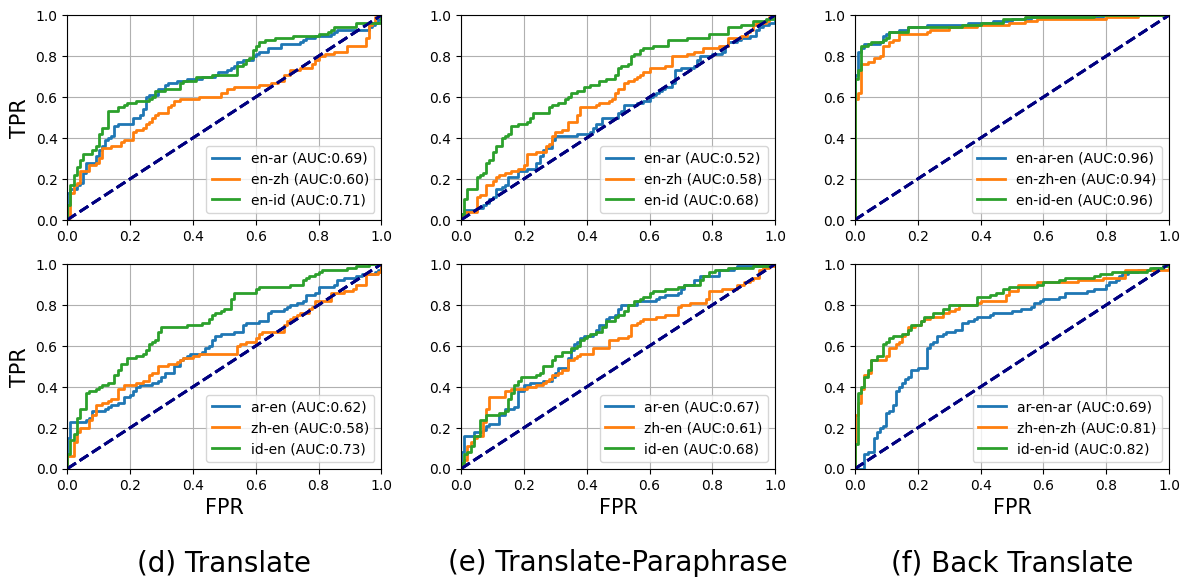

In [12]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves_xsir(fpr_range=(0.0, 1.0), delta=2.0, suffix=""):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    low, high = fpr_range
    save_path = f'figures/roc_curves_xsir_{suffix}.pdf'
    method = "XSIR"
    source_languages = ["English"]
    target_languages = ["Arabic", "Chinese", "Indonesian"]
    
    attack_dataframes = df_dict[method]
    for attack_index, (attack_type, df) in enumerate(attack_dataframes.items()):
        for row in df.itertuples():
            ax = axes[0, attack_index]
            # if row.src_lang in source_languages:
            #     ax = axes[0, attack_index]
            # elif row.src_lang in target_languages:
            #     ax = axes[1, attack_index]
            if row.src_lang in target_languages:
                # continue
                ax = axes[1, attack_index]
            try:
                scores = np.array(row.scores)
                true_scores = scores[:, 0]
                predicted_scores = scores[:, 2]
                if attack_type != "paraphrase->translation":
                    true_scores = scores[:, 0]
                    predicted_scores = scores[:, 3]
                y_true = np.concatenate((np.zeros(100), np.ones(100)))
                y_scores = np.hstack([true_scores, predicted_scores])
                fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                roc_auc = auc(fpr, tpr)
                label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]} (AUC:{roc_auc:.2f})"
                if attack_type in ["paraphrase->translation", "back-translation"]:
                    label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]}-{lang_dict_acronym[row.src_lang]} (AUC:{roc_auc:.2f})"
                ax.plot(fpr, tpr, lw=2, label=label)
            except ValueError as e:
                print(f"Error: {e}")
                print(f"For {row.src_lang}->{row.tgt_lang} {attack_type}")
                
                scores = np.nan_to_num(row.scores)
                true_scores = scores[:, 0]
                predicted_scores = scores[:, 2]
                if attack_type != "paraphrase->translation":
                    true_scores = scores[:, 0]
                    predicted_scores = scores[:, 3]
                y_true = np.concatenate((np.zeros(100), np.ones(100)))
                y_scores = np.hstack([true_scores, predicted_scores])
                fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                roc_auc = auc(fpr, tpr)
                label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]} (AUC:{roc_auc:.2f})"
                if attack_type in ["paraphrase->translation", "back-translation"]:
                    label = f"{lang_dict_acronym[row.src_lang]}-{lang_dict_acronym[row.tgt_lang]}-{lang_dict_acronym[row.src_lang]} (AUC:{roc_auc:.2f})"
                ax.plot(fpr, tpr, lw=2, label=label)

            ax.tick_params(axis='both', which='major', labelsize=10)
            ax.plot([0, high], [0, high], color='navy', lw=2, linestyle='--')
            ax.set_xlim([low, high])  # Set x-axis limits to zoom in
            ax.set_ylim([low, high])  # Adjust y-axis to focus on higher TPR values
            ax.get_xaxis().get_major_formatter().set_scientific(True)
            axes[1, attack_index].set_xlabel('FPR', fontsize=15)
            axes[0, 0].set_ylabel('TPR', fontsize=15)
            axes[1, 0].set_ylabel('TPR', fontsize=15)
            new_attack_type = attack_type
            if attack_type == "translation":
                new_attack_type = "translation [XSIR]"
            elif attack_type == "translation->paraphrase":
                new_attack_type = "translation->paraphrase [ours]"
            elif attack_type == "paraphrase->translation":
                new_attack_type = "back-translation"
            # axes[0, attack_index].set_title(f'{new_attack_type}', fontsize=13)
            ax.legend(loc="lower right", fontsize=10)
            ax.grid(True)
    letters = ['(d) Translate', '(e) Translate-Paraphrase', '(f) Back Translate']
    for i, ax in enumerate(axes[1]):
        # plt.subplots_adjust(bottom=-0.5)  # Add space at bottom for text
        ax.text(0.5, -0.5, letters[i], transform=ax.transAxes, ha='center', fontsize=20)#, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(save_path, format='pdf')
    plt.show()

# Plot ROC curves for XSIR method
plot_roc_curves_xsir(fpr_range=(0.0, 1.0), suffix="all_attacks_with_numbering")

In [43]:
# calculate the TPR@FPR=0.1
def calculate_tpr_at_fpr(data, language, method, fpr_threshold=0.01):
    tpr_at_fpr = []
    for idx, row in data.iterrows():
        z_scores = np.array(row['z_scores'])
        # Assuming binary classification for watermark detection
        # Here `y_true` can be generated assuming gold = 0, unwatermarked = 0, watermarked = 1
        # Generate labels and prediction scores
        # y_true = np.hstack([[0]*500, [1]*500])  # 500 unwatermarked, 500 watermarked
        y_true = np.concatenate((np.zeros(500), np.ones(500)))
        # y_scores = np.hstack([z_scores[:, 0], z_scores[:, 1], z_scores[:, 2]])
        y_scores = np.hstack([z_scores[:, 1], z_scores[:, 2]])
        
        # Calculate ROC Curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        
        # Find the TPR at the closest threshold to fpr_threshold %
        target_fpr_index = np.where(fpr <= fpr_threshold)[0][-1]

        # TPR at the closest threshold to fpr_threshold %
        tpr_at_fpr.append(tpr[target_fpr_index])


        # Another method with same results
        # Extract unwatermarked and watermarked scores
        # unwatermarked_scores = np.array([scores[1] for scores in z_scores])
        # watermarked_scores = np.array([scores[2] for scores in z_scores])

        # # Calculate the 99th percentile value from the unwatermarked scores for the threshold
        # threshold = np.percentile(unwatermarked_scores, 100 - fpr_threshold * 100)

        # # Calculate TPR: Fraction of watermarked scores above the threshold
        # true_positive_count = np.sum(watermarked_scores > threshold)
        # total_watermarked_count = len(watermarked_scores)
        # tpr_at_fpr.append(true_positive_count / total_watermarked_count)
        print(f'{method} {language}: TPR at FPR {fpr_threshold} for gamma={row["gamma"]}, delta={row["delta"]}: {tpr_at_fpr[-1]}')

    return tpr_at_fpr

In [44]:
for method, dict_vals in df_dict.items():
    for language, df in dict_vals.items():
        calculate_tpr_at_fpr(df, language, method, fpr_threshold=0.01)
        break
    break


KGW Arabic: TPR at FPR 0.01 for gamma=0.1, delta=2.0: 0.978
KGW Arabic: TPR at FPR 0.01 for gamma=0.5, delta=2.0: 0.992
KGW Arabic: TPR at FPR 0.01 for gamma=0.9, delta=2.0: 0.854
KGW Arabic: TPR at FPR 0.01 for gamma=0.1, delta=5.0: 1.0
KGW Arabic: TPR at FPR 0.01 for gamma=0.5, delta=5.0: 1.0
KGW Arabic: TPR at FPR 0.01 for gamma=0.9, delta=5.0: 0.964
KGW Arabic: TPR at FPR 0.01 for gamma=0.1, delta=10.0: 1.0
KGW Arabic: TPR at FPR 0.01 for gamma=0.5, delta=10.0: 1.0
KGW Arabic: TPR at FPR 0.01 for gamma=0.9, delta=10.0: 1.0


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
jais_model_name = "inceptionai/jais-family-6p7b"
sail_model_name = "sail/Sailor2-1B"
sail_tokenizer = AutoTokenizer.from_pretrained(sail_model_name)
jais_tokenizer = AutoTokenizer.from_pretrained(jais_model_name)

In [ ]:
from nltk.tokenize import word_tokenize
# this is for extra analysis of length ratios of translations.
def calculate_length_ratios(data, src_lang='English', tgt_lang='Chinese'):
    string_length_ratios = []
    token_length_ratios = []
    if src_lang == "English":
        if 'tgt_language' == 'Chinese' or 'tgt_language' == 'Indonesian':
            tokenizer = sail_tokenizer
        else:
            tokenizer = jais_tokenizer
    elif src_lang == "Chinese" or src_lang == "Indonesian":
        tokenizer = sail_tokenizer
    else:
        tokenizer = jais_tokenizer
    for item in data:
        src = item['src_lang']
        tgt = item['tgt_lang']
        # print(src, tgt)
        if src == src_lang and tgt == tgt_lang:
            data = item['data']
            for example in data[:100]:
                original_text = example['original_wm1']
                translated_text = example['attacked_wm1']

                # Method 1: Calculate ratio based on string length
                string_length_ratio = len(translated_text) / len(original_text)
                string_length_ratios.append(string_length_ratio)

                # Method 2: Calculate ratio based on tokenized text
                original_tokens = tokenizer.encode(original_text)
                translated_tokens = tokenizer.encode(translated_text)
                # print(tgt_lang)
                # print(original_tokens)
                # print(translated_tokens)
                token_length_ratio = len(translated_tokens) / len(original_tokens)
                token_length_ratios.append(token_length_ratio)
    # return the average ratios
    return np.mean(string_length_ratios), np.mean(token_length_ratios)


In [26]:
en_ar_str_ratio, en_ar_tok_ratio = calculate_length_ratios(all_data, src_lang='English', tgt_lang='Arabic')
en_zh_str_ratio, en_zh_tok_ratio = calculate_length_ratios(all_data, src_lang='English', tgt_lang='Chinese')
en_id_str_ratio, en_id_tok_ratio = calculate_length_ratios(all_data, src_lang='English', tgt_lang='Indonesian')
ar_en_str_ratio, ar_en_tok_ratio = calculate_length_ratios(all_data, src_lang='Arabic', tgt_lang='English')
zh_en_str_ratio, zh_en_tok_ratio = calculate_length_ratios(all_data, src_lang='Chinese', tgt_lang='English')
id_en_str_ratio, id_en_tok_ratio = calculate_length_ratios(all_data, src_lang='Indonesian', tgt_lang='English')

print(f"English-Arabic String Length Ratio: {en_ar_str_ratio}, Token Length Ratio: {en_ar_tok_ratio}")
print(f"English-Chinese String Length Ratio: {en_zh_str_ratio}, Token Length Ratio: {en_zh_tok_ratio}")
print(f"English-Indonesian String Length Ratio: {en_id_str_ratio}, Token Length Ratio: {en_id_tok_ratio}")
print()
print(f"Arabic-English String Length Ratio: {ar_en_str_ratio}, Token Length Ratio: {ar_en_tok_ratio}")
print(f"Chinese-English String Length Ratio: {zh_en_str_ratio}, Token Length Ratio: {zh_en_tok_ratio}")
print(f"Indonesian-English String Length Ratio: {id_en_str_ratio}, Token Length Ratio: {id_en_tok_ratio}")

English-Arabic String Length Ratio: 0.7953920508290574, Token Length Ratio: 0.836550402160158
English-Chinese String Length Ratio: 0.3600747036785805, Token Length Ratio: 1.7883523320940264
English-Indonesian String Length Ratio: 0.950505767568411, Token Length Ratio: 1.5028110973348652

Arabic-English String Length Ratio: 1.1030728240582213, Token Length Ratio: 0.9849379065378824
Chinese-English String Length Ratio: 1.8729648569166324, Token Length Ratio: 0.7235749136508933
Indonesian-English String Length Ratio: 0.76463463495404, Token Length Ratio: 0.6117542911403605
